In [302]:
%matplotlib ipympl
import time
import json
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.units import ureg
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev

In [7]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [8]:
def get_average_heights(data_number):
    data, headers = get_experiment_data(data_number)

    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    
    plt_monitor = True
    use_positive = None
    
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        chasm_avg = None
        antihole_normalized = antihole_avg / monitors_avg["antihole"]
        rf_normalized = rf_avg / monitors_avg["rf"]
    if "lf" in transmissions_avg:
        lf_normalized = transmissions_avg["lf"] / monitors_avg["lf"]
    
    if headers["params"]["field_plate"]["use"]:
        hat_E = headers["params"]["field_plate"]["amplitude"] > 0
        hat_probe = headers["params"]["field_plate"]["stark_shift"] > 0
        mask = detunings_MHz > 0
        mask1 = detunings_MHz < 0
        if "lf" in transmissions_avg:
            return (np.array([np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])]), 
            np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), 
            np.array([np.average(lf_normalized[mask]), np.average(lf_normalized[mask1])]), headers, (hat_E, hat_probe))
        else:
            return np.array([
                np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])
            ]), np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), headers, (hat_E, hat_probe)
            
    else:
        return np.average(antihole_normalized), np.average(rf_normalized), headers, None

def get_voltage_ratios(data_list):
    ratios = []
    ratios2 = []
    headers = []
    E_fields = []
    # for kk in data_list:
    #     h1, h2, h3, header, E_field = get_average_heights(kk)
    #     ratios.append(h2 / h1)
    #     ratios2.append((h3-h2)/(h2-h1))
    #     headers.append(header)
    #     E_fields.append(E_field)
    # return np.array(ratios), np.array(ratios2), headers, E_fields
    for kk in data_list:
        h1, h2, header, E_field = get_average_heights(kk)
        ratios.append(h2 / h1)
        headers.append(header)
        E_fields.append(E_field)
    return np.ones(len(ratios)), np.array(ratios), headers, E_fields

## Time-series Ramsey

In [9]:
def get_sine_fit(detunings, voltages, p0=None, bounds=None):
    def sine(f, f_0, t, a, c):
        return np.sin(2*np.pi*(f - f_0) * t) * a + c
    fitter = Fitter(sine)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0.001, "c": np.average(voltages), "t": 0.1, "a": (np.max(voltages) - np.min(voltages)) / 2})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.set_bounds("f_0", -1, 1)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

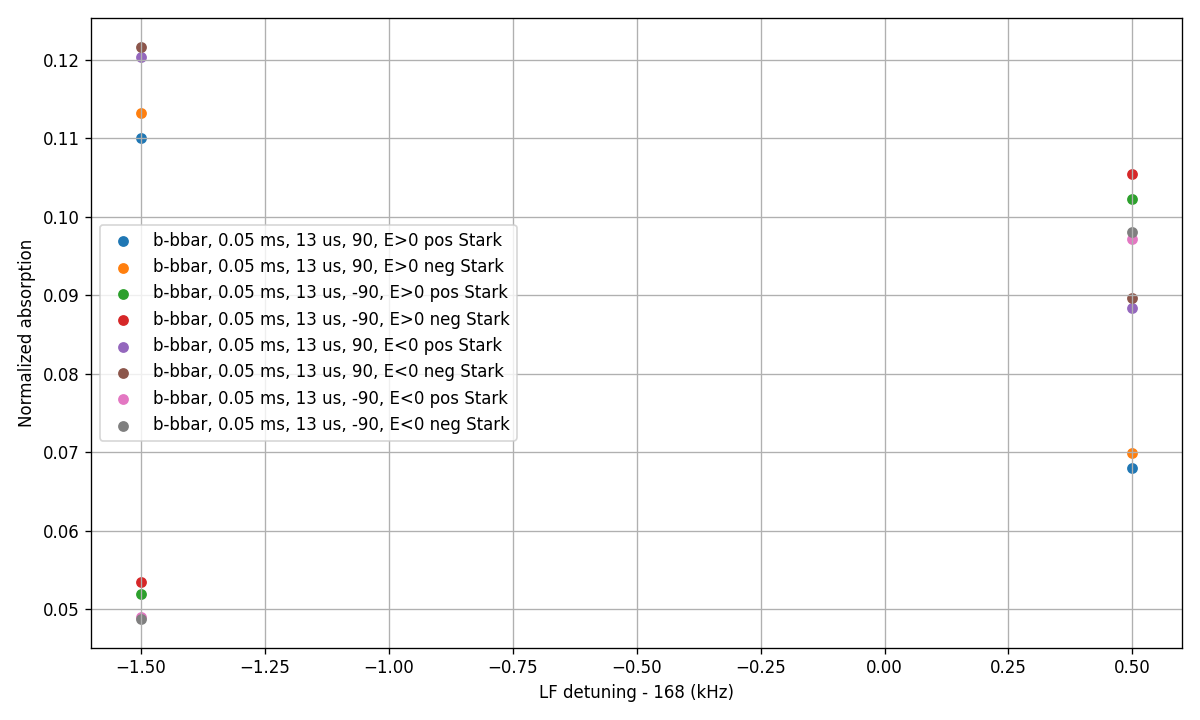

In [55]:
data = {
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (579736, 579755),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (579756, 579775),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (579776, 579795),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (579796, 579815),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 1": (579816, 579835),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 1": (579836, 579855),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 1": (579856, 579875),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 1": (579876, 579895),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 2": (580066, 580085),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 2": (580086, 580105),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 2": (580106, 580125),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 2": (580126, 580145),

    
    # "new params": (580680, 580699),
    # "new params 2": (580700, 580719),

    # "longer averaging": (580734, 580753),
    # "longer averaging 2": (580754, 580773),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (581177, 581178),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (581179, 581180),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (581181, 581182),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (581183, 581184),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 1": (581290, 581291),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 1": (581292, 581293),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 1": (581294, 581295),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 1": (581296, 581297),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 2": (581830, 581831),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 2": (581832, 581833),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 2": (581834, 581835),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 2": (581836, 581837),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 3": (582214, 582215),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 3": (582216, 582217),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 3": (582218, 582219),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 3": (582220, 582221),
}

# new sequence
data = {
    # "T pi/2 = 0.013 ms": (610325, 610334),
    # "T pi/2 = 0.0125 ms": (610553, 610560),
    # "T pi/2 = 0.0135 ms": (610563, 610572),
    # "T pi/2 = 0.014 ms": (610573, 610582),
    # "T pi/2 = 0.0145 ms": (610585, 610594),
    # "T C pi/2 = 0.0142 ms": (610613, 610622),
    # "T C pi/2 = 0.013 ms": (610633, 610642),
    # "T C pi/2 = 0.0132 ms": (610649, 610657),
    # "T pi/2 = 0.0145 ms repeat": (610658, 610667),
    # "0.5 wait time": (610725, 610734),
    # "0.5 wait time 2": (610735, 610744),
    # "0.5 wait time 3": (610745, 610754),
    # "0.5 wait time 4": (610755, 610764),
    # "4-pt-test2": (610686, 610687),
    # "0.3 ms": (610835, 610854),
    # "0.1 ms": (610860, 610864),
    # "0.05 ms": (610973, 610992),
    # "0.05 ms 2": (610993, 611012),
    # "1": (611244, 611249),
    # "2": (611250, 611255),
    # "3": (611256, 611261),
    # "4": (611065, 611066) 
    # "": (611325, 611334),
    # "2": (611335, 611344),
    # "rf_b, 50 us, 1": (612123, 612132),
    # "rf_b, 50 us, 2": (612133, 612142),
    # "rf_b, 50 us, 3": (612143, 612152),
    # "rf_b, 50 us, 4": (612153, 612162),
    # "rf_b, 100 us, 1": (612194, 612203),
    # "rf_b, 100 us, 2": (612204, 612213),
    # "rf_b, 100 us, 3": (612214, 612223),
    # "rf_b, 100 us, 4": (612224, 612233),
    "b-bbar, 0.05 ms, 13 us, 90, E>0": (612760, 612761),
    "b-bbar, 0.05 ms, 13 us, -90, E>0": (612762, 612763),
    "b-bbar, 0.05 ms, 13 us, 90, E<0": (612764, 612765),
    "b-bbar, 0.05 ms, 13 us, -90, E<0": (612766, 612767), #
}
plt_background = False

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios1, ratios2, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios1)
    y2s = 1-ratios2
    if E_field[0] is not None:
        if not plt_background:
            ax.scatter(xs, y2s[:,0], label=label + " pos Stark", s = 30)
            ax.scatter(xs, y2s[:,1], label=label + " neg Stark", s = 30)
        else:
            ax.scatter(xs, ys[:,0], label=label + "1 pos Stark", s = 30)
            ax.scatter(xs, ys[:,1], label=label + "1 neg Stark", s = 30)
            
        #ax.scatter(xs, ys[:,0], label=label + "1 pos Stark", s = 30)
        #ax.scatter(xs, y2s[:,0], label=label + " pos Stark", s = 30)
        # pos_fit = get_sine_fit(xs, y2s[:, 0]/ys[:,0])
        # ax.plot(xs, pos_fit.fitted_value(xs))
        #ax.scatter(xs, ys[:,1], label=label + "1 neg Stark", s = 30)
        #ax.scatter(xs, y2s[:,1], label=label + " neg Stark", s = 30)
        # neg_fit = get_sine_fit(xs, y2s[:, 1]/ys[:, 1])
        # ax.plot(xs, neg_fit.fitted_value(xs))

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [307]:
data = {
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (579736, 579755),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (579756, 579775),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (579776, 579795),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (579796, 579815),
    
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (580066, 580085),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (580086, 580105),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (580106, 580125),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (580126, 580145),

    
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (580734, 580753),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (580754, 580773),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (580774, 580793),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (580794, 580813),


    # T_violation data 1 day
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (581218, 581219),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (581220, 581221),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (581222, 581223),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (581224, 581225), # 588206


    # T_violation data 1 day using 100X antihole repeats (~12 HOURS)
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (601009, 601010),  # 100 ah repeats, Jun 26 night
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (601011, 601012),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (601013, 601014),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (601015, 601016),  # 607440


    # # T_violation data 1 day using 400X of antihole repeats (~1 HOUR 20 MINUTES)
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (607483, 607484),  # 400 ah repeats, Jun 27 morning
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (607485, 607486),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (607487, 607488),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (607489, 607490), #607870

    
    # # T_violation data 1 day using 400X of antihole repeats, shorter antihole durations, 1 detection (**)
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (607874, 607875),  # 400 ah repeats, Jun 27 morning
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (607876, 607877),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (607878, 607879),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (607880, 607881), #608297

    
    # T_violation data 1 day using 100x of antihole repeats, 100 h run
    "b-bbar, 0.05 ms, 13 us, 90, E<0": (612760, 612761),
    "b-bbar, 0.05 ms, 13 us, -90, E<0": (612762, 612763),
    "b-bbar, 0.05 ms, 13 us, 90, E>0": (612764, 612765),
    "b-bbar, 0.05 ms, 13 us, -90, E>0": (612766, 612767), # 647177

    # SAME AS ABOVE DATA BUT IGNORE FIRST 1000
    # T_violation data 1 day using 100x of antihole repeats, 100 h run
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (613760, 613761),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (613762, 613763),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (613764, 613765),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (613766, 613767), # 647177
}
max = 815723

total_exp_time = (get_experiment_data(max)[1]["data_info"]["save_epoch_time"] - get_experiment_data(data["b-bbar, 0.05 ms, 13 us, 90, E>0"][0])[1]["data_info"]["save_epoch_time"])/3600

fs = {}
f1 = []
f2 = []
Es = []

for kk in data:
    fs[kk] = []

all_results = []

current = data[list(data.keys())[-1]][1]
offset = 0
while current + offset <= max:
    for ll, (label, data_range) in enumerate(data.items()):
        if ll % 2 == 1:
            continue
        data_range_1 = (data_range[0] + offset, data_range[1] + offset)
        data_list1 = data_identification_to_list(data_range_1)
        ratios_bg, ratios, headers, E_field = get_voltage_ratios(data_list1)
        xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
        ys = (1-ratios)
        data_range_2 = (data_range[0] + offset + 2, data_range[1] + offset + 2)
        data_list2 = data_identification_to_list(data_range_2)
        ratios_bg, ratios, headers, E_field = get_voltage_ratios(data_list2)
        y1s = (1-ratios)
        E_field_1 = list(data)[ll].split(", ")[-1] == "E>0"
        E_field_2 = list(data)[ll+1].split(", ")[-1] == "E>0"
        if E_field_1 != E_field_2:
            raise Exception("Must use data for the same E field")

        xs = (np.array(xs) + headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude) * 1000
        xs_diff = xs[1] - xs[0]
        for kk in range(2):
            ys_red_diff = ys[0][kk] - y1s[0][kk]
            ys_blue_diff = y1s[1][kk] - ys[1][kk]
            x_center = xs_diff * ys_red_diff / (ys_red_diff + ys_blue_diff) + xs[0]
            neg_DdotE = kk == 0
            E = E_field_1
            D = (not neg_DdotE) == E
            detect_order = E_field[0][1]
            data_indices = list(data_list1) + list(data_list2)
            epoch_times = (
                get_experiment_data(data_range_1[0])[1]["data_info"]["save_epoch_time"],
                get_experiment_data(data_range_2[-1])[1]["data_info"]["save_epoch_time"],
            )
            all_results.append(
                {
                    "freq_center": x_center,
                    "E": E,
                    "D": D,
                    "detect_red_first": detect_order,
                    "data_indices": data_indices,
                    "save_epoch_times": epoch_times,
                }
            )
            
    offset += 2 * 4

f1 = np.array(f1)
f2 = np.array(f2)

In [306]:
if input(f"Create new analysis folder? (y/n) ") == "y":
    analysis_folder_index = open_analysis_folder("lf_spectroscopy")
else:
    analysis_folder_index = int(input("Enter analysis number: "))
print("Current analysis number: ", analysis_folder_index)
with open(get_analysis_file_path(analysis_folder_index, "all_data.json"), "w") as f:
    json.dump(all_results, f)

Create new analysis folder? (y/n)  n
Enter analysis number:  607


Current analysis number:  607


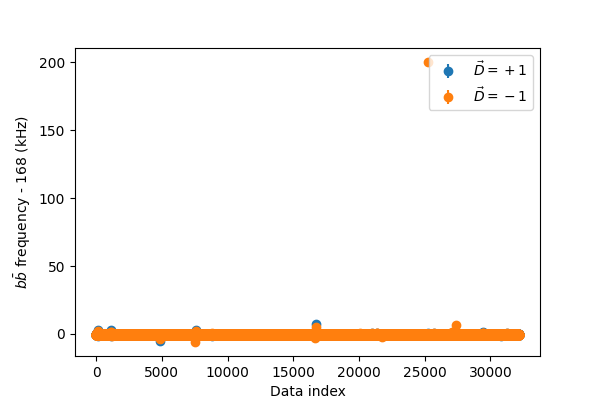

In [171]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(f1)), unumpy.nominal_values(f1), unumpy.std_devs(f1), fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(np.arange(len(f2)), unumpy.nominal_values(f2), unumpy.std_devs(f2), fmt="o", label="$\\vec{D}=-1$")


ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency - 168 (kHz)")
ax.legend()
plt.show()

1800
total experiment time = 108.72771737496058 h
f_plus = -0.44601 +/- 0.00041 kHz
f_minus = -0.48275 +/- 0.00042 kHz
f_plus - f_minus = 0.03673 +/- 0.00007 kHz


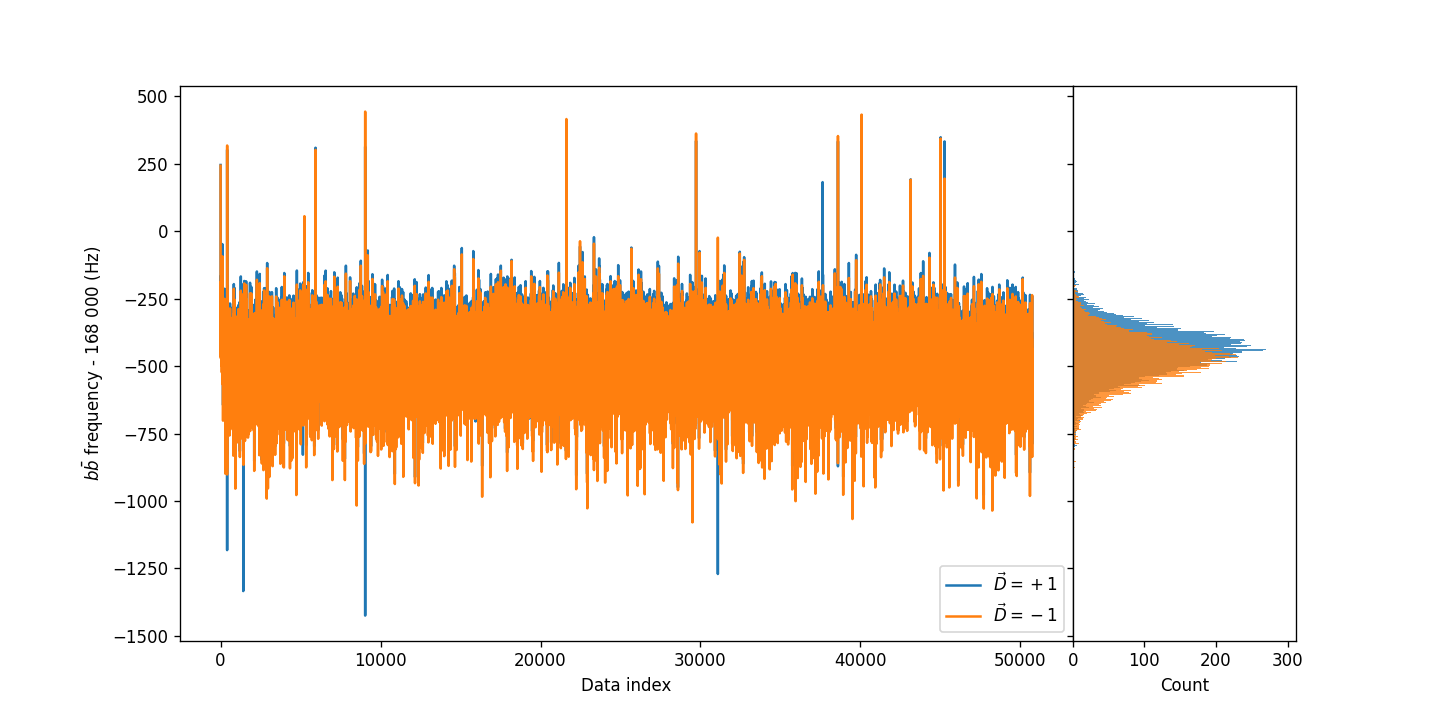

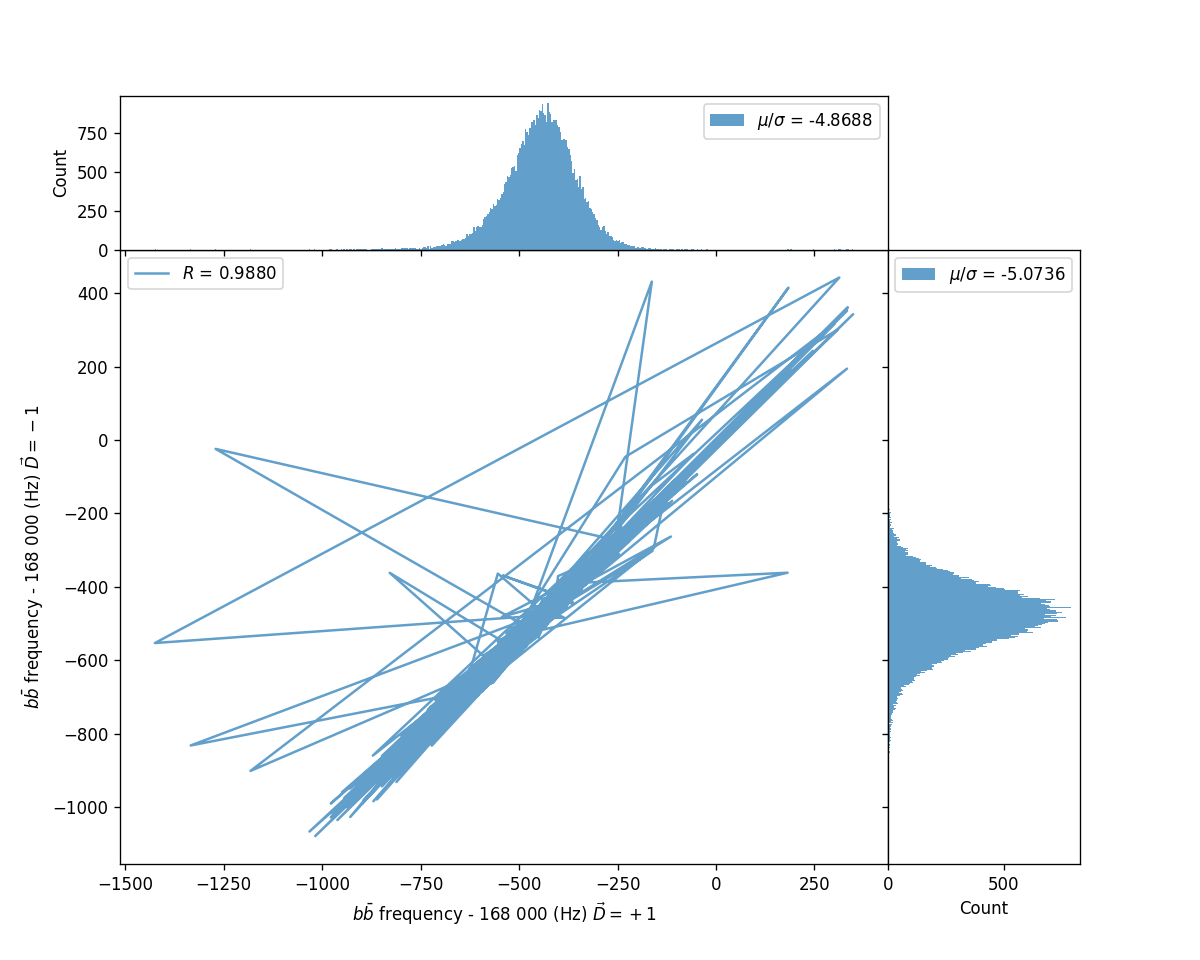

In [202]:
def mask_array(array):
    return array  # all array
    return array[::2]  # all even indices
    return array[1::2]  # all odd indices


xs1 = mask_array(np.arange(len(f1)))
ys1 = mask_array(unumpy.nominal_values(f1))
ys1_err = mask_array(unumpy.std_devs(f1))

xs2 = mask_array(np.arange(len(f2)))
ys2 = mask_array(unumpy.nominal_values(f2))
ys2_err = mask_array(unumpy.std_devs(f2))

f_diff = f1 - f2
xs3 = mask_array(np.arange(len(f_diff)))
ys3 = mask_array(unumpy.nominal_values(f_diff))
ys3_err = mask_array(unumpy.std_devs(f_diff))

delete_mask = np.ones(len(xs1), dtype=bool)
for kk in range(len(xs1)):
    if abs(ys1[kk] + 0.5) > 1 or abs(ys2[kk] + 0.5) > 1:
        delete_mask[kk] = False
xs1 = xs1[delete_mask]
ys1 = ys1[delete_mask]
ys1_err = ys1_err[delete_mask]
xs2 = xs2[delete_mask]
ys2 = ys2[delete_mask]
ys2_err = ys2_err[delete_mask]
xs3 = xs3[delete_mask]
ys3 = ys3[delete_mask]
ys3_err = ys3_err[delete_mask]

n_bins = int(np.sqrt(len(f1))) * 8
print(n_bins)
bins_alpha = 0.8

fig, axs = plt.subplots(1, 2, figsize = (12, 6), dpi = 120, sharey='row', gridspec_kw={'width_ratios': [4, 1]})
axs[0].plot(xs1, ys1*1000., label="$\\vec{D}=+1$")
_ = axs[1].hist(ys1*1000., bins=n_bins, orientation='horizontal', alpha=bins_alpha)
# axs[0].plot([np.min(xs1), np.max(xs1)], [np.average(ys1), np.average(ys1)])

axs[0].plot(xs2, ys2*1000., label="$\\vec{D}=-1$")
_ = axs[1].hist(ys2*1000., bins=n_bins, orientation='horizontal', alpha=bins_alpha)

axs[0].set_xlabel("Data index")
axs[1].set_xlabel("Count")
axs[0].set_ylabel("$b\\bar{b}$ frequency - 168 000 (Hz)")
axs[0].legend()
# axs[0].set_ylim([200, 600])

print(f"total experiment time = {total_exp_time} h")
print(f"f_plus = {np.average(ys1):.5f} +/- {np.std(ys1) / np.sqrt(len(ys1)):.5f} kHz")
print(f"f_minus = {np.average(ys2):.5f} +/- {np.std(ys2) / np.sqrt(len(ys2)):.5f} kHz")
print(f"f_plus - f_minus = {np.average(ys3):.5f} +/- {np.std(ys3) / np.sqrt(len(ys3)):.5f} kHz")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig = plt.figure(figsize = (10, 8), dpi = 120)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
xs = ys1*1000
ys = ys2*1000
bins = 500



colors = plt.cm.jet(np.linspace(0, 1, len(ys)))
for color, x, y in zip(colors, xs, ys):  # change this to heat map or something
    ax.plot(x, y, color = color, alpha=0.7)#, label = f"$R$ = {pearsonr(xs, ys).statistic:.4f}")
    
ax.plot(xs, ys, alpha=0.7, label = f"$R$ = {pearsonr(xs, ys).statistic:.4f}")
ax_histx.hist(xs, bins=bins, alpha=0.7, label=f"$\\mu/\\sigma$ = {np.average(xs)/np.std(xs):.4f}")
ax_histy.hist(ys, bins=bins, alpha=0.7, orientation='horizontal', label=f"$\\mu/\\sigma$ = {np.average(ys)/np.std(ys):.4f}")

ax.set_xlabel("$b\\bar{b}$ frequency - 168 000 (Hz) $\\vec{D}=+1$")
ax.set_ylabel("$b\\bar{b}$ frequency - 168 000 (Hz) $\\vec{D}=-1$")
ax_histx.set_ylabel("Count")
ax_histy.set_xlabel("Count")
ax.legend()
ax_histx.legend()
ax_histy.legend()
plt.show()



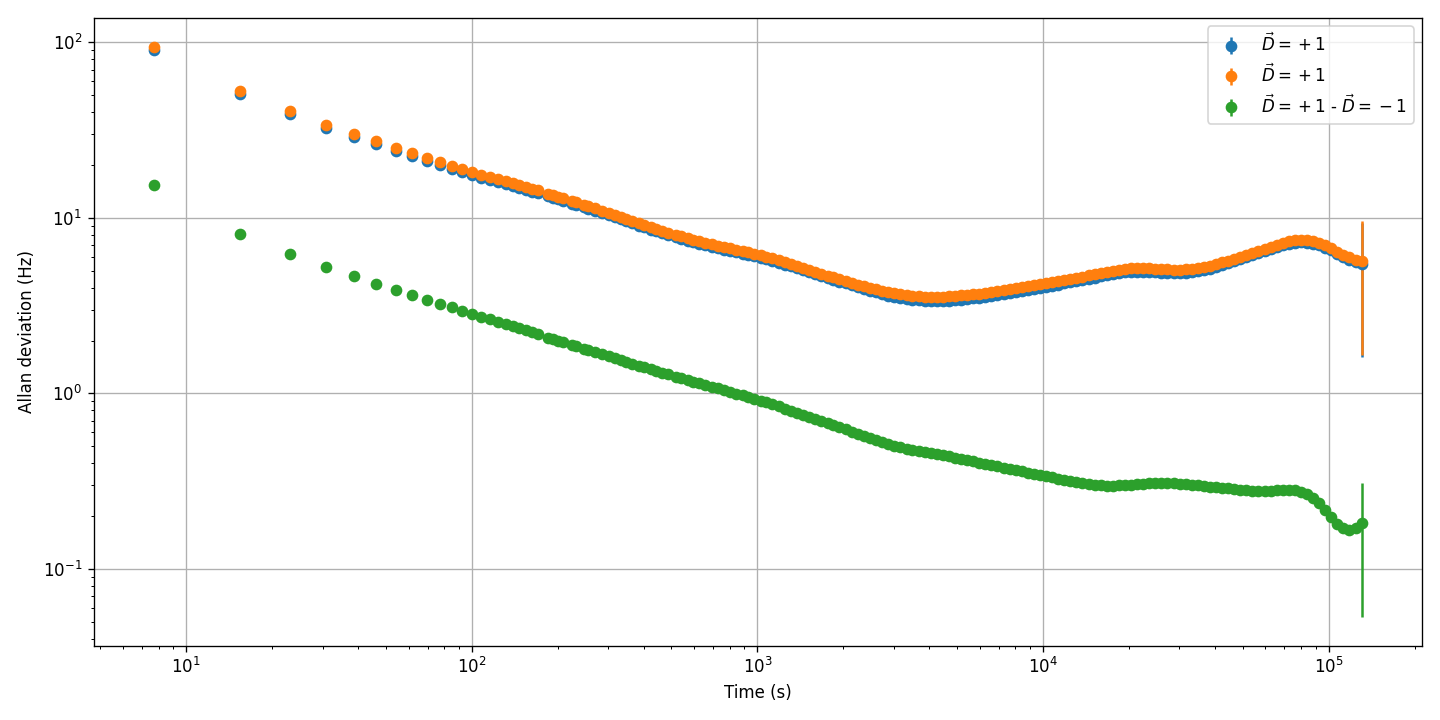

In [238]:
taus1 = np.logspace(0, np.log10(len(ys1) // 3), 200)
real_taus1, allan1, allan_err1, _ = allantools.mdev(ys1 * 1000, data_type="freq", taus=taus1)
real_taus1 *= total_exp_time * 3600 / len(ys1)

taus2 = np.logspace(0, np.log10(len(ys2) // 3), 200)
real_taus2, allan2, allan_err2, _ = allantools.mdev(ys2 * 1000, data_type="freq", taus=taus2)
real_taus2 *= total_exp_time * 3600 / len(ys2)

taus3 = np.logspace(0, np.log10(len(ys1) // 3), 200)
real_taus3, allan3, allan_err3, _ = allantools.mdev(ys3 * 1000, data_type="freq", taus=taus3)
real_taus3 *= total_exp_time * 3600 / len(ys1)

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
ax.errorbar(real_taus1, allan1, allan_err1, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus2, allan2, allan_err2, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus3, allan3, allan_err3, fmt="o", label="$\\vec{D}=+1$ - $\\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

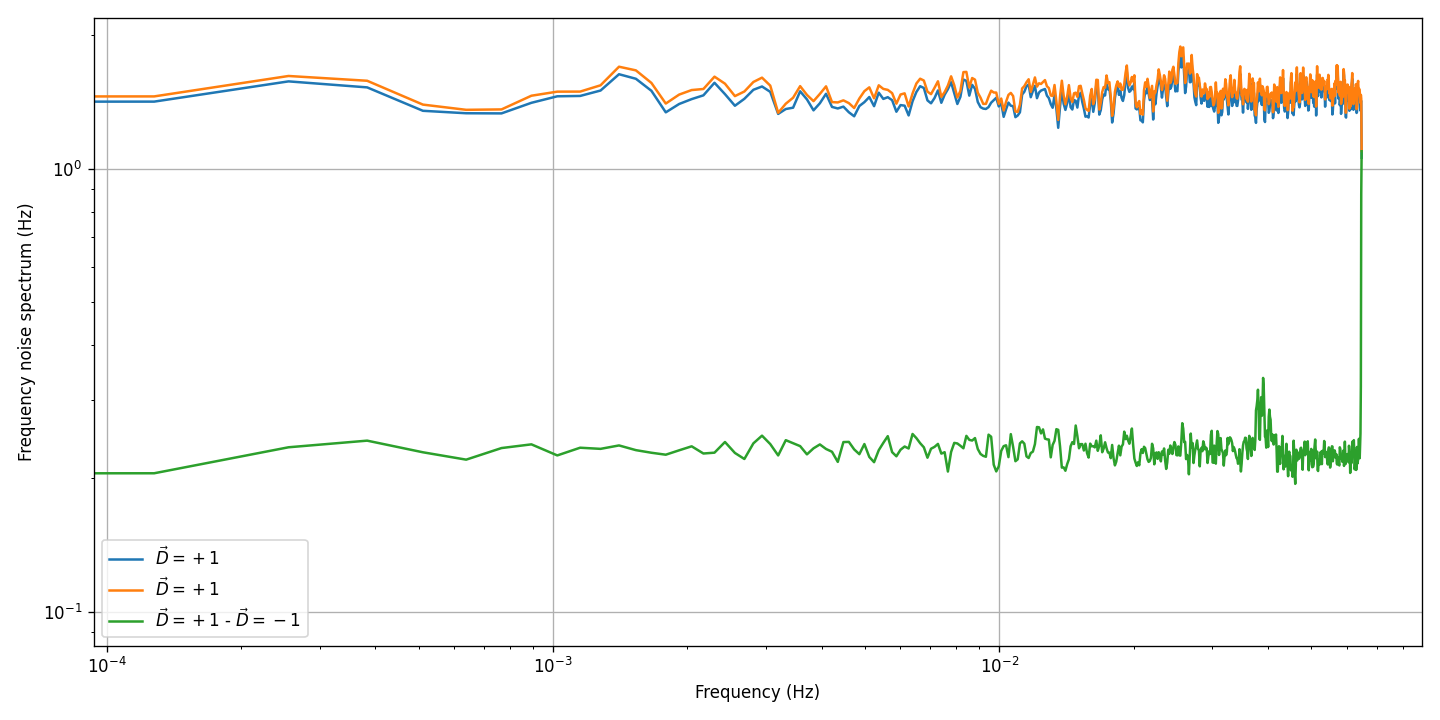

In [289]:
from scipy.signal import welch

freqs1, powers1 = welch(ys1 * 1000, nperseg=int(len(ys1) / 50))
# powers1_fft = np.abs(np.fft.rfft(ys1 * 1000 - np.average(ys1) * 1000)) ** 2
# freqs1_fft = np.fft.rfftfreq(len(ys1))
freqs1 *= len(ys1) / (total_exp_time * 3600)
noise_spectrum1 = np.sqrt(powers1 * (freqs1[1] - freqs1[0]))
freqs2, powers2 = welch(ys2 * 1000, nperseg=int(len(ys2) / 50))
freqs2 *= len(ys2) / (total_exp_time * 3600)
noise_spectrum2 = np.sqrt(powers2 * (freqs2[1] - freqs2[0]))
freqs3, powers3 = welch(ys3 * 1000, nperseg=int(len(ys3) / 50))
freqs3 *= len(ys3) / (total_exp_time * 3600)
noise_spectrum3 = np.sqrt(powers3 * (freqs3[1] - freqs3[0]))

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
ax.plot(freqs1, noise_spectrum1, label="$\\vec{D}=+1$")
# ax.plot(freqs1_fft, powers1_fft / 30000, label="$\\vec{D}=+1$")
ax.plot(freqs2, noise_spectrum2, label="$\\vec{D}=+1$")
ax.plot(freqs3, noise_spectrum3, label="$\\vec{D}=+1$ - $\\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Frequency noise spectrum (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [248]:
len(ys1) / (total_exp_time * 3600)

0.12954378460302066

## Fluctuations in LF Ramsey (1 data point)

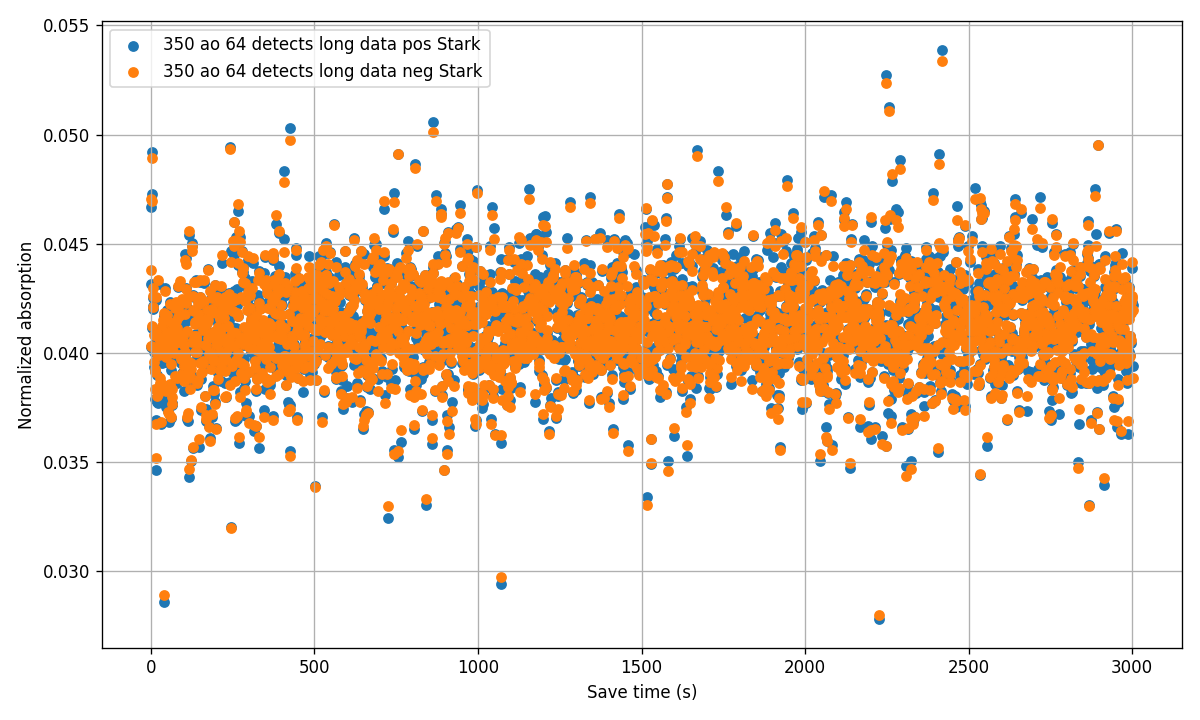

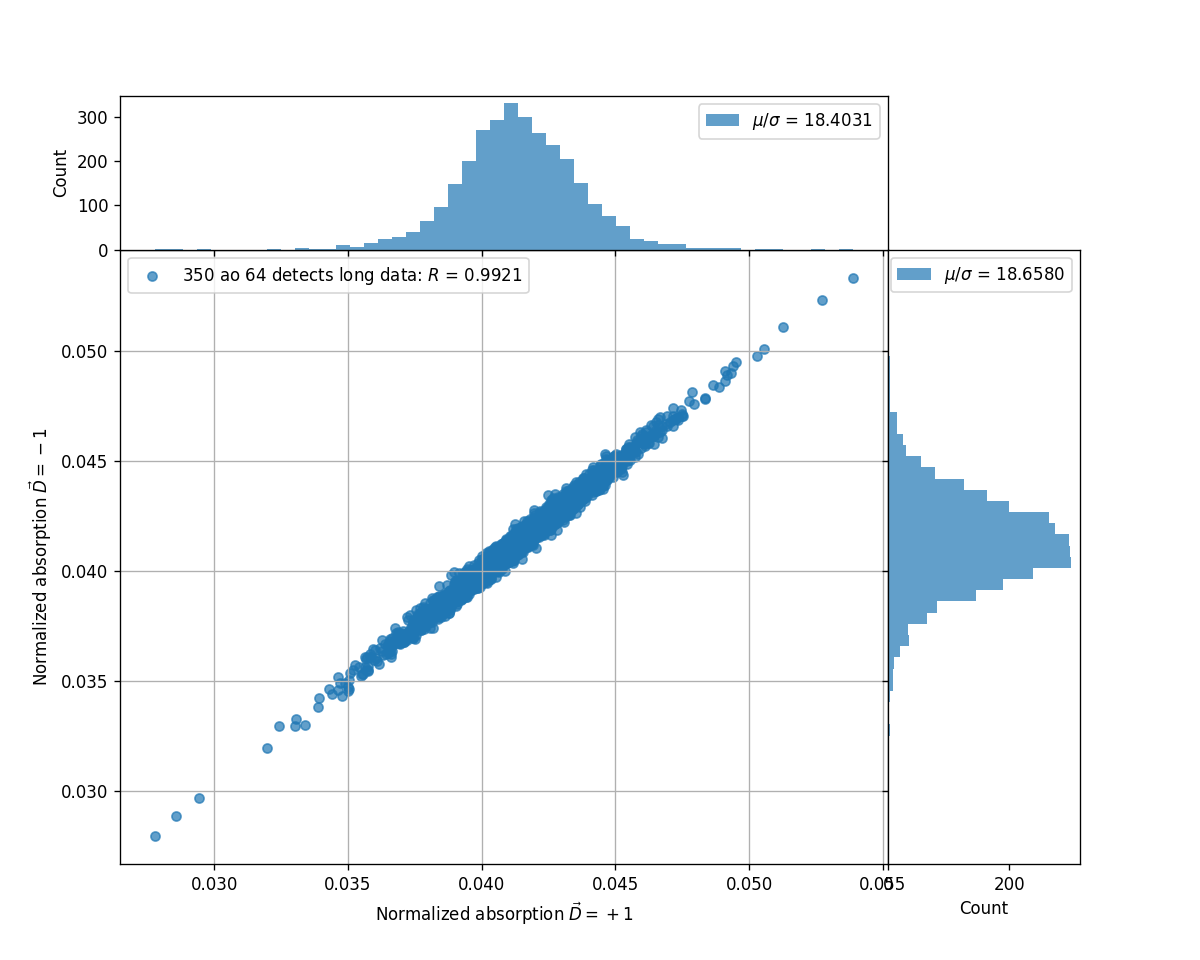

In [193]:
data = {
    # "original": (588222, 588418),
    # "sync 0.713(0.01)s": (592518, 592702),
    # "no sync": (592704, 592916),
    # "sync 0.713(0.001)s": (592923, 593092),
    # "no sync 2": (593094, 593306),
    # "no sync 3": (593328, 593553),


    # COMPARISON:    
    # "350 ao 32 detects": (594308, 594529),
    # "350 ao 64 detects": (594531, 594752),
    # "350 ao 256 detects": (594754, 594972),
    # "400 ao 64 detects": (594974, 595192),
    # "425 ao 64 detects": (595417, 595638),
    # "450 ao 64 detects": (595194, 595415),
    # "400 ao 64 detects rep": (595640, 595863),
    # "350 ao 64 detects rep": (595865, 596088),


    "350 ao 64 detects long data": (596089, 599091),
    # "350 ao 64 detects long data (SAME BUT IGNORE FIRST 1000)": (597089, 599091),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    # xs = [header["data_info"]["save_epoch_time"]-headers[0]["data_info"]["save_epoch_time"] for header in headers]
    xs = [i for i in range(len(headers))]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
        # ax.scatter(xs, ys[:,0]-ys[:,1], label=label + "$\\vec{D}=+1$ - $\\vec{D}=-1$", s = 30)

ax.set_xlabel(f"Save time (s)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (10, 8), dpi = 120)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xsys = (1-ratios)
    xs = xsys[:, 0]
    ys = xsys[:, 1]
    bins = 50
    ax.scatter(xs, ys, s = 30, alpha=0.7, label = f"{label}: $R$ = {pearsonr(xs, ys).statistic:.4f}")
    ax_histx.hist(xs, bins=bins, alpha=0.7, label=f"$\\mu/\\sigma$ = {np.average(xs)/np.std(xs):.4f}")
    ax_histy.hist(ys, bins=bins, alpha=0.7, orientation='horizontal', label=f"$\\mu/\\sigma$ = {np.average(ys)/np.std(ys):.4f}")

ax.set_xlabel("Normalized absorption $\\vec{D}=+1$")
ax.set_ylabel("Normalized absorption $\\vec{D}=-1$")
ax_histx.set_ylabel("Count")
ax_histy.set_xlabel("Count")
ax.grid()
ax.legend()
ax_histx.legend()
ax_histy.legend()
plt.show()



0.9945744020212515

## Fluctuations in Hole burning

0.004199764272051945
0.006971096344848625
0.003937793905072617
0.0034490014055966814


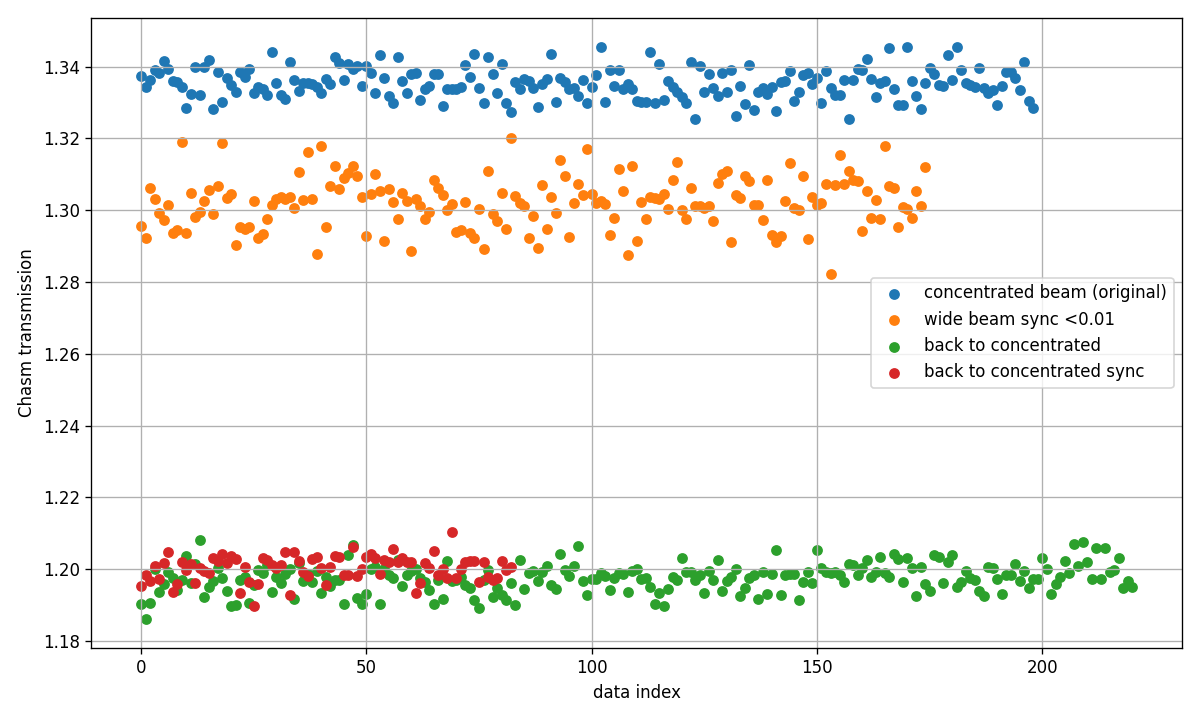

In [159]:
data = {
    # "chasm -> immediate detect": (588421, 588753)

    # chasm -> immediate detect -> wait -> detect
    "concentrated beam (original)": (589333, 589531),
    # "3 decimal sync": (590121, 590239),
    # "wider beam diameter": (590407, 591294),
    # "back to concentrated beam 2": (591568, 591693),
    # "wide beam 2": (591916, 592043),
    # "wide beam sync <0.1": (592090, 592150),
    "wide beam sync <0.01": (592271, 592445),
    "back to concentrated": (593659, 593879),
    "back to concentrated sync": (593891, 593973),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ys = []
    xs = []
    for kk, data_num in enumerate(data_list):
        transmissions_avg, monitors_avg, headers = averaged_data_from_number(data_num)
        # xs.append(headers["data_info"]["save_epoch_time"])
        xs.append(kk)
        ys.append((transmissions_avg["antihole"][0]/monitors_avg["antihole"][0]))
    print(np.std(ys))
    ax.scatter(xs, ys, s = 30, label=label)

ax.set_xlabel(f"data index")
ax.set_ylabel("Chasm transmission")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

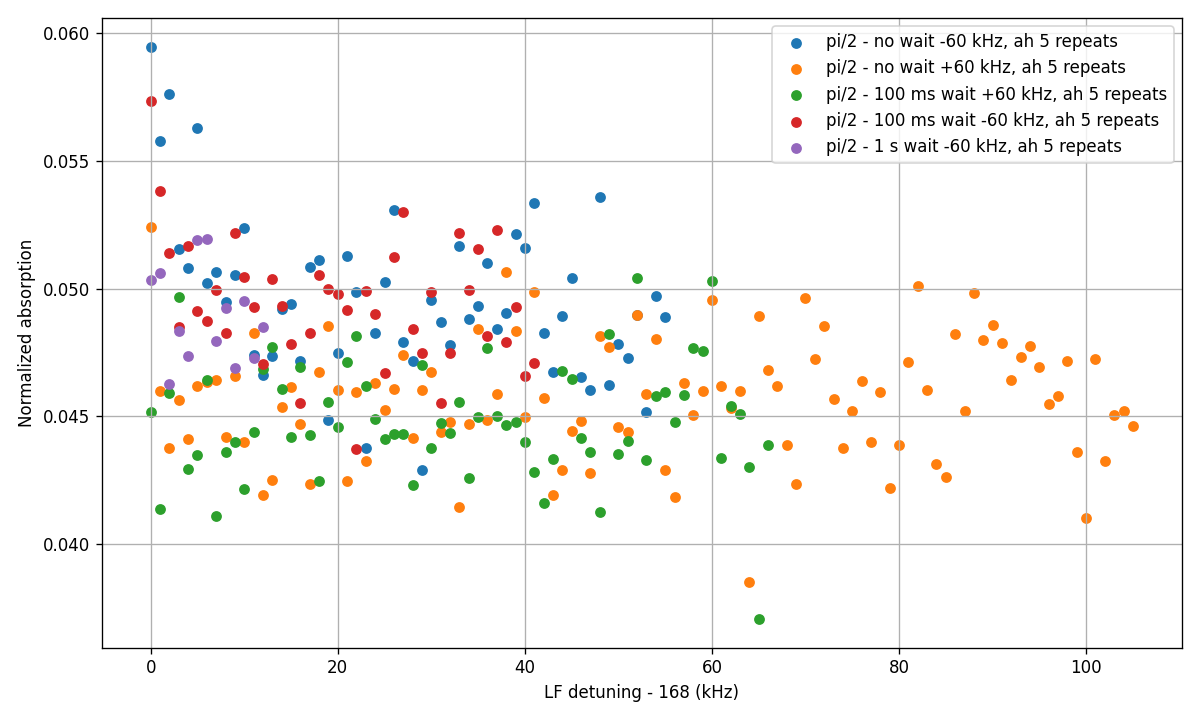

In [274]:
data = {
    # "pi/2 - no wait -60 kHz": (609490, 609544),
    # "pi/2 - no wait +60 kHz": (609545, 609591),
    # "pi/2 - no wait no rf": (609603, 609647),
    # "rf_b +60 kHz": (609649, 609707),
    # "rf_b -60 kHz": (609709, 609741),
    # "pi/2 - no wait +60 kHz, ah 20 repeats": (609743, 609826),
    # "pi/2 - no wait -60 kHz, ah 20 repeats": (609828, 609930),
    "pi/2 - no wait -60 kHz, ah 5 repeats": (609932, 609987),
    "pi/2 - no wait +60 kHz, ah 5 repeats": (609989, 610094),
    "pi/2 - 100 ms wait +60 kHz, ah 5 repeats": (610097, 610163),
    "pi/2 - 100 ms wait -60 kHz, ah 5 repeats": (610176, 610217),
    "pi/2 - 1 s wait -60 kHz, ah 5 repeats": (610249, 610261),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["data_info"]["data_number"] for header in headers]
    xs = np.array(xs) - xs[0]
    ys = (1-ratios)[:, 0]
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()